In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
from xmitgcm import open_mdsdataset

from osse import *
from sloped_MITgcm import *
from canyon_utils import *
from wmt import *

#### Constant parameters

In [3]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = dx
delta_t = 15.

#### Plot WMTs

In [4]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"

ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
ds = ds.sel(time=ds['time'][20:][::20])
#ds = ds.isel(time=[-2, -1]) # COMMENT OUT IN PRODUCTION
ds = add_thalweg(ds)

extend_multiples = [-5, 1]
Lx = dx*ds.XC.size
ds = periodic_extend(ds, ['XC', 'XG'], Lx, extend_multiples)
ds, grid = add_rotated_coords(ds, θ)

ds['THETA_BG_C'] = Γ*ds['Zr']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']
ds['θ'] = ds['θ'].where(ds['hFacC'] != 0)
ds = add_temp_budget(ds, grid, Γ, θ)
ds = add_hab_coordinates(ds, grid, vert_coord='Z', gridface='C')

ds['days'] = ds['time'].astype('float64')/(86400.*1e9) - 1250.

In [5]:
Lx, Ly = ds.XC.size*dx, ds.YC.size*dy
cint = k0*Γ*np.cos(θ)*Ly*Lx
cbot = k1*Γ*np.cos(θ)*Ly*Lx

In [6]:
dθ = 0.05
θmax = 1.
θmin = 0.
Δθ = θmax - θmin
θlevs = np.arange(θmin-dθ, θmax+dθ, dθ)

dz = 5.
hlevs = np.append( np.arange(-dz/2, 200.-dz, dz), np.arange(200., 1000.+dz*5, dz*5) )

In [7]:
ds_regions = {}
ds_regions['total'] = ds[['θ', 'diff_tendency_TH']]
ds_regions['canyon'] = irregular_section(ds[['θ', 'diff_tendency_TH']], ds['j_thalweg'].values, width=5)
ds_regions['outside'] = irregular_section(ds[['θ', 'diff_tendency_TH']], ds['j_thalweg'].values, width=21, invert_mask=True)
ds_regions['flanks'] = ds[['θ', 'diff_tendency_TH']].where((np.isnan(ds_regions['canyon'])) & (np.isnan(ds_regions['outside'])))

In [8]:
wmt_dict = {}
for label, d in ds_regions.items():
    print(label, end='\n')
    
    wmt_dict[label] = xr.Dataset()
    wmt_dict[label]['mask'] = ~np.isnan(d['θ'].isel(time=-1, Z=0)).load()
    wmt_dict[label].attrs['area'] = (wmt_dict[label]['mask'].sum(skipna=True)*dx*dy).values
    
    mixing = d['diff_tendency_TH'].fillna(0.)

    wmt_dict[label]['E_net'] = histogram(
        d['θ'],
        bins=[θlevs],
        weights=mixing,
        dim=('XC', 'YC', 'Z',)
    ).load()/dθ;

    wmt_dict[label]['E_BBL'] = histogram(
        d['θ'],
        bins=[θlevs],
        weights=mixing.where(mixing > 0., 0.),
        dim=('XC', 'YC', 'Z',)
    ).load()/dθ;

    wmt_dict[label]['E_SML'] = histogram(
        d['θ'],
        bins=[θlevs],
        weights=mixing.where(mixing < 0., 0.),
        dim=('XC', 'YC', 'Z',)
    ).load()/dθ;
    
    wmt_dict[label]['E_hab'] = histogram(
        d['Z_habC'].broadcast_like(d["θ"]),
        bins=[hlevs],
        weights=mixing.where((d["θ"] > 0.) & (d["θ"] <= 1.), 0.),
        dim=('XC', 'YC', 'Z',)
    ).load()/Δθ;
    
    dhab = np.diff(hlevs)
    wmt_dict[label]["dZ_habC_bin"] = xr.DataArray(dhab, coords={"Z_habC_bin": wmt_dict[label]["Z_habC_bin"].values}, dims="Z_habC_bin")

total


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


canyon


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


outside


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))


flanks


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))

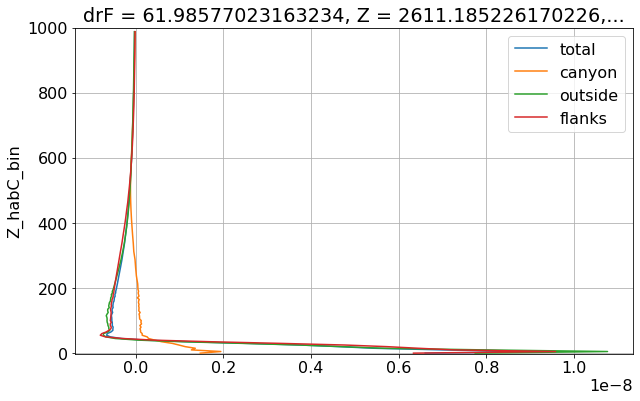

In [10]:
for label, d in ds_regions.items():
    da = wmt_dict[label]["E_hab"].mean("time")/wmt_dict[label].attrs["area"]
    dhab = wmt_dict[label]["dZ_habC_bin"]
    (da/dhab).plot(y="Z_habC_bin", label=label)
    plt.ylim(-2, 1000)
    plt.grid(True)
    plt.legend()

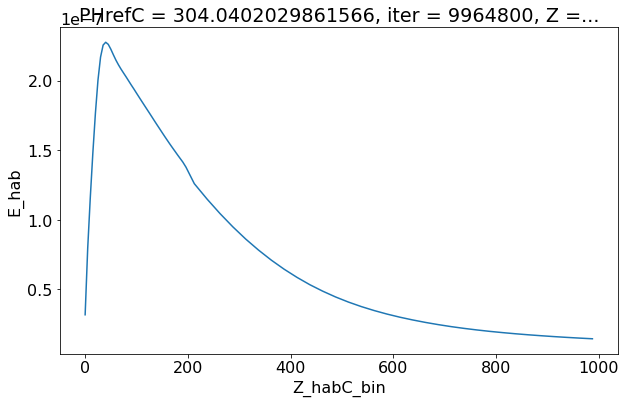

In [165]:
(da).cumsum("Z_habC_bin").plot()

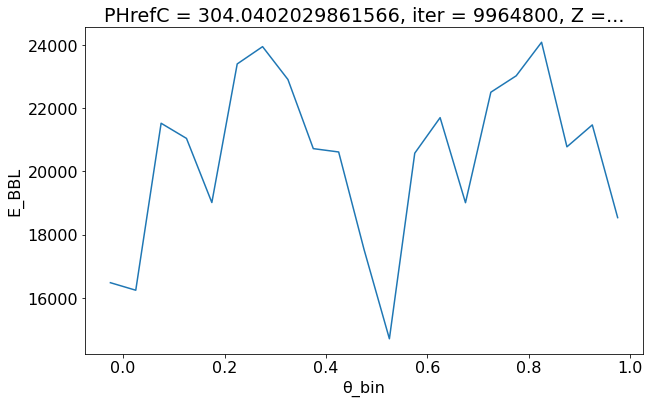

In [166]:
wmt_dict[label]['E_BBL'].mean("time").plot()

#### Save WMT calculations

In [9]:
for k,v in wmt_dict.items():
    saving = v.copy()
    saving.to_netcdf(f"../../data/BBTRE-physics/wmt_{k}.nc", mode='w')